In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, EndogVar, EndogVarConditions, EndogEquation, System, Constraint, OptimizerType
from torchquad import MonteCarlo
from torch.func import hessian, jacrev, vmap

In [2]:
a = 1
# def compute_u(x):
#     return torch.sin(x[:, 0]) + torch.cos(x[:, 1])

# def compute_u_x(x):
#     return torch.stack([torch.cos(x[:, 0]), - torch.sin(x[:, 1])], dim=1) 

# def compute_u(x):
#     a = 2/3
#     b = (4-2**0.5)/3
#     res1 = x[..., 0] - a
#     res2 = x[..., 1] - b
#     res3 = x[..., 0] + x[..., 1] - b
#     res = torch.relu(res1)
#     res = torch.maximum(res, res2)
#     res = torch.maximum(res, res3)
#     return res

# def compute_u_x(x):
#     return vmap(jacrev(compute_u), chunk_size=500)(x)

def compute_integrand(compute_u, compute_u_x, x):
    x = x.reshape(-1, 2)
    u = compute_u(x)
    u_x = compute_u_x(x).reshape(-1, 2)
    return torch.einsum("bi,bi->b", x, u_x) - u.reshape(-1) - torch.einsum("bi,bi->b", u_x, u_x) / 2

def compute_energy(compute_u, compute_u_x):
    integration_domain = [[a, a+1]] * 2
    mc = MonteCarlo()
    return mc.integrate(lambda x: compute_integrand(compute_u, compute_u_x, x), dim=2, integration_domain=integration_domain)

model = PDEModel("principal_agent", config={"num_epochs": 2000, "optimizer_type": OptimizerType.Adam})
model.set_state(["x", "y"], {"x": [a, a+1.], "y": [a, a+1.]})
model.register_function(compute_energy)
model.add_endog("u", config={"batch_jac_hes": True})
model.add_equation("lap = torch.sum(torch.diagonal(u_Hess, dim1=2, dim2=3), dim=-1)")
model.add_equation("deth = torch.det(u_Hess)")
model.add_constraint("u", Comparator.GEQ, "0", loss_reduction="SAE")
model.add_constraint("u_Jac", Comparator.GEQ, "0", loss_reduction="SAE")
model.add_constraint("lap", Comparator.GEQ, "0", loss_reduction="SAE")
model.add_constraint("deth", Comparator.GEQ, "0", loss_reduction="SAE")
model.add_constraint("lap", Comparator.LEQ, "3", loss_reduction="SAE")
model.add_hjb_equation("-compute_energy(compute_u, compute_u_Jac)", loss_reduction="None")
print(model)
if not os.path.exists("./models/principal_agent/model_2d.pt"):
    model.train_model("./models/principal_agent", "model_2d.pt", True)
    model.load_model(torch.load("./models/principal_agent/model_2d.pt", weights_only=False))
    model.eval_model(True)
else:
    model.load_model(torch.load("./models/principal_agent/model_2d.pt", weights_only=False))
    model.eval_model(True)

========================Summary of Model principal_agent========================
Config: {
 "batch_size": 100,
 "num_epochs": 2000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "UniformRandom",
 "refinement_rounds": 5,
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{}
User Defined Parameters:
{}

================================State Variables=================================
x: [1, 2.0]
y: [1, 2.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: u
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=30, bias=True)
    (activation_0): Tanh()
   

d:\UofT\Research\PDE-work\continuous-time-eco-models\venv\Lib\site-packages\torchquad\integration\utils.py:248: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


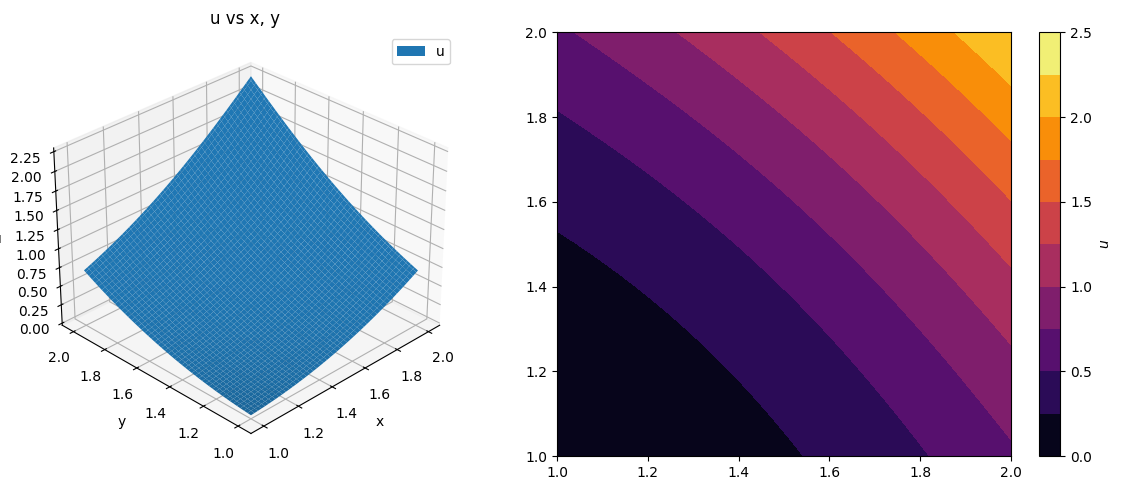

In [4]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection="3d")
model.endog_vars["u"].plot("u", {"x": [a, a+1], "y": [a,a+1]}, ax=ax)
ax.view_init(30, -135, 0)

ax1 = fig.add_subplot(1, 2, 2)
x_vals = torch.linspace(a, a+1, 100)
y_vals = torch.linspace(a, a+1, 100)
X, Y = torch.meshgrid(x_vals, y_vals, indexing="ij")
SV = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1)
u = model.endog_vars["u"].forward(SV)
c = ax1.contourf(X.detach().numpy(), Y.detach().numpy(), u.detach().numpy().reshape(100, 100), levels=10, cmap="inferno")
fig.colorbar(c, ax=ax1, label="$u$")

plt.tight_layout()
plt.show()